In [8]:
import sys
sys.path.append('../')

from torch.utils.data import TensorDataset
from torch import Tensor
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib
import seaborn as sns; sns.set_style('white')

from main import *
plt = matplotlib.pyplot

# Introduction
Though the Bayesian paradigm is theoretically appealing, it has proved difficult to apply in deep learning. 
Consider a neural network $f_\theta: X \to Y$. For illustrative purposes, suppose the model is given by
$$
p(y|x,\theta) \propto \exp\{-|| y - f_\theta(x) ||^2/2\}
$$
Let $\varphi(\theta)$ be the prior distribution and $p(\mathcal D_n |\theta) = \Pi_{i=1}^n p(y_i | x_i, \theta)$ be the likelihood of the data $\mathcal D_n = \{(x_i,y_i)\}_{i=1}^n$. Then the posterior distribution of $\theta$ is given by
$$
p(\theta | \mathcal D_n) \propto p(\mathcal D_n | \theta) \varphi(\theta).
$$
The normalizing constant in the posterior distribution is an intractable integral. Many methods for sampling from the posterior, e.g., MCMC, variational inference, will encounter extra difficulty when $\theta$ is a high dimensional neural network weight. 

Leaving aside the fact that the posterior is hard to sample, let's see why we should care about the posterior distribution in the first place. In the Bayesian paradigm, we predict using a distribution
$$
p(y|x, \mathcal D_n) = \int p(y|x,\theta) p(\theta|\mathcal D_n) \,d\theta
$$
Thus instead of providing a point estimate $\hat y$ for input $\hat x$, we can form an entire distribution estimate which lends itself naturally to uncertainty quantification. 

There is yet another advantage to Bayesian prediction, perhaps less well documented in the deep learning community. Neural networks are singular models. In terms of generalization, Bayesian prediction is better than MAP or MLE for singular models. This phenomenon is what we seek to elucidate in this work. 

# Generalization error


Suppose $\hat q_n(y|x)$ is some estimate of the true unknown conditional density $q(y|x)$. The generalization error of the prediction $\hat q(y|x)$ is defined as
$$
G(n) = KL (q(y|x) || \hat q(y|x) ) = \int \int q(y|x) \log \frac{q(y|x)}{\hat q_n(y|x)} \,dy q(x) \,dx
$$
We've written this in terms of the sample size $n$ to remind ourselves that $\hat q_n$ is formed using $\mathcal D_n$. 

We will consider three predictors of $q(y|x)$:
+ Bayesian predictive distribution $\hat q(y|x) = p(y|x,\mathcal D_n)$
+ MAP $\hat q(y|x) = p(y|x,\theta_n^{MAP}$)
+ MLE $\hat q(y|x) = p(y|x,\theta_n^{MLE}$)

To average out the randomness in the dataset $\mathcal D_n$ used to form the predictors, we will ultimately look at the average generalization error 
\begin{equation}
E_n G(n) 
\label{eq:avgGn}
\end{equation}
where $E_n$ denotes expectation over the dataset $\mathcal D_n$. In simulations, we calculate the average generalization error using a held-out-test set $T_{n'} = \{(x_i',y_i')\}_{i=1}^{n'}$ as
\begin{equation}
\frac{1}{n'} \sum_{i=1}^{n'} \log q(y_i'|x_i') - E_n \frac{1}{n'} \sum_{i=1}^{n'} \log \hat q_n(y_i'|x_i')
\label{eq:computed_avgGn}
\end{equation}
Assume the held-out test set is large enough so that the difference between \ref{eq:avgGn} and \ref{eq:computed_avgGn} is negligible. We will refer to them interchangeably as the average generalization error. 

# Bayes versus MAP versus MLE in singular models

A singular model is ...

Neural networks are singular models because ...

Since $p(y|x,\theta)$ is singular, we look to Watanabe's singular learnng theory to understand the generalization error of the various predictors considered. Assume the true distribution is realizable by the model, i.e., $q(y|x) = p(y|x,\theta_0)$ for some $\theta_0$ (though we will investigate violations of this assumption in the experiments).

We have the following asymptotic expansions of the generalization error for singular models. 
+ For Bayes, $E_n G(n) = \lambda/n + o(1/n)$ where $\lambda \in \mathbb Q^+$ is a positive rational number known as the learning coefficient. The learning coefficient is completely determined by the the truth-model-prior triplet $( q(y|x), p(y|x,\theta), \varphi(\theta) )$. Most of the time $\lambda << dim(\theta)/2$
+ For MAP and MLE, $E_n G(n) = C/n + o(1/n)$ (different $C$'s for MAP and MLE). Basically $C$ is the maximum of some Gaussian process, which can easily be greater than $dim(\theta)/2$. Watanabe's Main Theorem 6.4 gives the precise formulation. 

# Last layer Bayesian 

Though the Bayes predictive distribution is provably superior to MAP and MLE, it relies on the intractable posterior distribution. As a workaround, we form the predictive distribution only in the last layer(s) of a deep neural network. Since a neural network $f_\theta$ is naturally hierarchical, we break it up into $f_\theta = h_w \circ g_v$ where $\theta = (v,w)$ with $dim(w)$ being small enough to manageably perform MCMC. 

Let $\theta_{map} = (v_{map},w_{map})$. Let $\tilde x_i = g_{v_{map}}(x_i)$. Define a new transformed dataset $\tilde{\mathcal D_n} = \{(\tilde x_i, y_i) \}_{i=1}^n$. We perform MCMC to sample the posterior over $w$:
$$
p(w | \tilde{\mathcal D_n}) \propto p(\tilde{\mathcal D_n} | w) \varphi(w) = \Pi_{i=1}^n \exp\{-|| y_i - h_w \circ g_{v_{map}}(x_i) ||^2/2\} \varphi(w)
$$

Define the last layer Bayesian predictive distribution to be 
$$
p_{LLB}(y|x, \mathcal D_n) = \int p(y|x,(v_{map},w)) p(w|\tilde{\mathcal D_n}) \,dw
$$
It would seem that the generalization error of $p_{LLB}$ should also be on the order $\lambda/n$ but with $\lambda$ corresponding to the triplet $( q(y|\tilde x), p(y|\tilde x, w), \varphi(w))$. For certain functions $h_w$ where the true $\lambda$ is known, we can verify this hunch in the experiments. 

But more interestingly, we would like to know if the learning coefficient of $p_{LLB}$ is smaller than the learning coefficient of $p_{\theta_{map}}$ or $p_{\theta_{mle}}$. 

# Experiments

Consider a neural network set up as follows

We use the following values for the parameters
+ input_dim = output_dim = rr_hidden = 3
+ ffrelu_hidden = 5


In [9]:
class Model(nn.Module):

    def __init__(self, input_dim, output_dim, ffrelu_hidden, rr_hidden):
        super(Model, self).__init__()

        self.feature_map = nn.Sequential(
            nn.Linear(input_dim, ffrelu_hidden),
            nn.ReLU(),
            nn.Linear(ffrelu_hidden, ffrelu_hidden),
            nn.ReLU(),
            nn.Linear(ffrelu_hidden, input_dim),
        )

        self.rr = nn.Sequential(
            nn.Linear(input_dim, rr_hidden, bias=False),
            nn.Linear(rr_hidden, output_dim, bias=False)
        )

    def forward(self, x):
        x = self.feature_map(x)
        return self.rr(x)


We generate the training data as follows: 
+ $X \sim N(0,\sigma_x^2 I_3)$
+ realizability
    + realizable $Y \sim N(f_{\theta_0}(X),\sigma_y^2 I_3)$
    + not realizable $Y \sim N(h_{w_0}(X),\sigma_y^2 I_3)$
    
For the testing data, we consider a possible change in the support of $X$:
+ $X \sim \alpha N(0,\sigma_x^2 I_3)$ for some scale $\alpha \in \mathbb R^+$.

In [10]:
def get_data(args):

    train_size = int(args.n)
    valid_size = int(args.n * 0.5)
    test_size = int(10000)

    a = Normal(0.0, 1.0)
    a_params = 0.2 * a.sample((args.input_dim, args.rr_hidden))
    b = Normal(0.0, 1.0)
    b_params = 0.2 * b.sample((args.rr_hidden, args.output_dim))

    X_rv = MultivariateNormal(torch.zeros(args.input_dim), torch.eye(args.input_dim))
    y_rv = MultivariateNormal(torch.zeros(args.output_dim), torch.eye(args.output_dim))
    true_model = Model(args.input_dim, args.output_dim, args.ffrelu_hidden, args.rr_hidden)
    true_model.eval()

    with torch.no_grad():
        # training +valid data
        X = X_rv.sample(torch.Size([train_size+valid_size]))
        if args.realizable:
            true_mean = true_model(X)
        else:
            true_mean = torch.matmul(torch.matmul(X, a_params), b_params)
        y = true_mean + y_rv.sample(torch.Size([train_size+valid_size]))
        dataset_train, dataset_valid = torch.utils.data.random_split(TensorDataset(X, y),[train_size,valid_size])

        # testing data
        X = args.X_test_std * X_rv.sample(torch.Size([test_size]))
        if args.realizable:
            true_mean = true_model(X)
        else:
            true_mean = torch.matmul(torch.matmul(X, a_params), b_params)
        y = true_mean + y_rv.sample(torch.Size([test_size]))
        dataset_test = TensorDataset(X, y)
        oracle_mse = (torch.norm(y - true_mean, dim=1)**2).mean()
        entropy = -torch.log((2 * np.pi) ** (-args.output_dim / 2) * torch.exp(
            -(1 / 2) * torch.norm(y - true_mean, dim=1) ** 2)).mean()

        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batchsize, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=args.batchsize, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=args.batchsize, shuffle=True)

    return train_loader, valid_loader, test_loader, oracle_mse, entropy

Note that the way MAP training is usually conducted in deep learning may involve early stopping. Watanabe's theory does not account for early stopping. We will try MAP training with and without early stopping.


In [11]:
def map_train(args, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, oracle_mse):

    model = Model(args.input_dim, args.output_dim, args.ffrelu_hidden, args.rr_hidden)
    opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
    early_stopping = EarlyStopping(patience=10, verbose=False, taskid=args.taskid)

    # TODO: is it necessary to implement mini batch SGD?
    for it in range(5000):
        model.train()
        y_pred = model(X_train).squeeze()
        l = (torch.norm(y_pred - Y_train, dim=1)**2).mean()
        l.backward()
        opt.step()
        opt.zero_grad()

        model.eval()
        with torch.no_grad():
            valid_loss = (torch.norm(model(X_valid).squeeze() - Y_valid, dim=1)**2).mean()
            
        if it % 100 == 0:
            model.eval()
            ytest_pred = model(X_test).squeeze()
            test_loss = (torch.norm(ytest_pred - Y_test, dim=1)**2).mean()
            print('MSE: train {:.3f}, validation {:.3f}, test {:.3f}, oracle on test set {:.3f}'.format(l.item(), valid_loss, test_loss.item(), oracle_mse))

        if args.early_stopping:
            early_stopping(valid_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

    return model


The last function we will need is for drawing samples from the last layers. Although the code supports implicit variational inference (and even explicit variational inference), only the MCMC (NUTS) will be considered in the experiments. 

In [12]:
def lastlayer_approxinf(model, args, X_train, Y_train, X_valid, Y_valid, X_test, Y_test):
    
    transformed_X_train = model.feature_map(X_train)
    transformed_X_valid = model.feature_map(X_valid)
    transformed_X_test = model.feature_map(X_test)

    transformed_train_loader = torch.utils.data.DataLoader(
        TensorDataset(Tensor(transformed_X_train), torch.as_tensor(Y_train, dtype=torch.long)),
        batch_size=args.batchsize, shuffle=True)
    transformed_valid_loader = torch.utils.data.DataLoader(
        TensorDataset(Tensor(transformed_X_valid), torch.as_tensor(Y_valid, dtype=torch.long)), 
        batch_size=args.batchsize, shuffle=True)

    if args.posterior_method == 'ivi':

        # parameters for train_implicitVI
        mc = 1
        beta_index = 0
        args.betas = [1.0]
        saveimgpath = None
        args.dataset = 'reducedrank_synthetic'
        args.H = args.rr_hidden

        # TODO: strip train_implicitVI to simplest possible inputs
        G = train_implicitVI(transformed_train_loader, transformed_valid_loader, args, mc, beta_index, saveimgpath)
        eps = torch.randn(args.R, args.epsilon_dim)
        sampled_weights = G(eps)
        list_of_param_dicts = weights_to_dict(args, sampled_weights)

        pred_prob = 0
        output_dim = transformed_X_test.shape[1]
        for param_dict in list_of_param_dicts:
            mean = torch.matmul(torch.matmul(transformed_X_test, param_dict['a']), param_dict['b'])
            pred_prob += (2 * np.pi) ** (-output_dim / 2) * torch.exp(-(1 / 2) * torch.norm(Y_test - mean, dim=1) ** 2)

    elif args.posterior_method == 'mcmc':

        wholex = transformed_train_loader.dataset[:][0]
        wholey = transformed_train_loader.dataset[:][1]
        beta = 1.0

        kernel = NUTS(conditioned_pyro_rr, adapt_step_size=True)
        mcmc = MCMC(kernel, num_samples=args.R, warmup_steps=args.num_warmup, disable_progbar=True)
        mcmc.run(pyro_rr, wholex, wholey, args.rr_hidden, beta)
        sampled_weights = mcmc.get_samples()

        pred_prob = 0
        output_dim = wholey.shape[1]
        for r in range(0, args.R):
            mean = torch.matmul(torch.matmul(transformed_X_test, sampled_weights['a'][r,:,:]), sampled_weights['b'][r,:,:])
            pred_prob += (2 * np.pi) ** (-output_dim / 2) * torch.exp(-(1 / 2) * torch.norm(Y_test - mean, dim=1) ** 2)

    return -torch.log(pred_prob / args.R).mean()


We set the arguments below. We are interested in examining the following three factors
+ realizability or not
+ support of $X_{test}$
+ early stopping or not

For the realizable plus non-early-stopping setting, we expect the learning coefficient for the last layer Bayes predictive distribution to match the theoretically known values of $\lambda$ for reduced rank regression. Watanabe's theory, as it stands, seems unable to say anything meaningful in the case $q$ is unrealizable by the model or in the case that MAP is trained using early stopping.

The computational overhead comes from the following variables:
+ num_warmup: burn-in for MCMC
+ MCs: number of training datasets for assessing $E_n$
+ num_n: number of sample sizes considered for drawing learning curve $1/n$ versus $E_n G(n)$
+ R: number of MCMC samples from the posterior

We've set these numbers to be very small for the purpose of running quickly in the notebook. 

In [ ]:
class Args:

    taskid = 1

    input_dim = 3
    output_dim = 3
    X_test_std = 1.0 # play around with
    realizable = 1 # play around with

    ffrelu_hidden = 5
    rr_hidden = 3
    early_stopping = 0 # play around with

    posterior_method = 'mcmc'
    num_warmup = 10


    batchsize = 50
    #   epsilon_mc = 100
    #   epochs = 100
    #   pretrainDepochs = 100
    #   trainDepochs = 20
    #   n_hidden_D = 128
    #   num_hidden_layers_D = 1
    #   n_hidden_G = 128
    #   num_hidden_layers_G = 1
    #   lr_primal = 0.01
    #   lr_dual = 0.001

    MCs = 5
    R = 10
    num_n = 10
    
    no_cuda = True
    log_interval = 10

args=Args()

args.cuda = not args.no_cuda and torch.cuda.is_available()

# change to boolean
if args.early_stopping == 0:
    args.early_stopping = False
else:
    args.early_stopping = True
if args.realizable == 0:
    args.realizable = False
else:
    args.realizable = True

args.epsilon_dim = args.rr_hidden*(args.input_dim + args.output_dim)
# TODO: w_dim and total_param_count depend on model and shouldn't be hardcoded as follows
args.w_dim = args.rr_hidden*(args.input_dim + args.output_dim)
total_param_count = (args.input_dim + args.rr_hidden + args.input_dim) * args.rr_hidden + args.w_dim


Below we plot the learning curve, i.e., $n$ versus $E_n G(n)$. (Actually we'll plot $1/n$ versus $E_n G(n)$ to easily assess whether the slope matches the theoretical $\lambda$.)

In [ ]:
avg_lastlayerbayes_gen_err = np.array([])
std_lastlayerbayes_gen_err = np.array([])
avg_map_gen_err = np.array([])
std_map_gen_err = np.array([])
avg_entropy = np.array([])
std_entropy = np.array([])

n_range = np.round(1/np.linspace(1/200,1/10000,args.num_n))

for n in n_range:

    map_gen_err = np.empty(args.MCs)
    lastlayerbayes_gen_err = np.empty(args.MCs)
    entropy_array = np.empty(args.MCs)

    args.n = n

    for mc in range(0, args.MCs):

        train_loader, valid_loader, test_loader, oracle_mse, entropy = get_data(args)
        entropy_array[mc] = entropy

        X_train = train_loader.dataset[:][0]
        Y_train = train_loader.dataset[:][1]
        X_valid = valid_loader.dataset[:][0]
        Y_valid = valid_loader.dataset[:][1]
        X_test = test_loader.dataset[:][0]
        Y_test = test_loader.dataset[:][1]

        model = map_train(args, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, oracle_mse)

        model.eval()
        map_gen_err[mc] = -torch.log((2*np.pi)**(-args.output_dim /2) * torch.exp(-(1/2) * torch.norm(Y_test-model(X_test), dim=1)**2)).mean() - entropy

        Bmap = list(model.parameters())[-1]
        Amap = list(model.parameters())[-2]
        params = (args.input_dim, args.output_dim, np.linalg.matrix_rank(torch.matmul(Bmap, Amap).detach().numpy()), args.rr_hidden)
        trueRLCT = theoretical_RLCT('rr', params)
        print('true RLCT {}'.format(trueRLCT))

        lastlayerbayes_gen_err[mc] = lastlayer_approxinf(model, args, X_train, Y_train, X_valid, Y_valid, X_test, Y_test) - entropy

        print('n = {}, mc {}, gen error: map {}, bayes last layer {}'
              .format(n, mc, map_gen_err[mc], lastlayerbayes_gen_err[mc]))


    print('average gen error: MAP {}, bayes {}'
          .format(map_gen_err.mean(), lastlayerbayes_gen_err.mean()))

    avg_lastlayerbayes_gen_err = np.append(avg_lastlayerbayes_gen_err, lastlayerbayes_gen_err.mean())
    std_lastlayerbayes_gen_err = np.append(std_lastlayerbayes_gen_err, lastlayerbayes_gen_err.std())
    avg_map_gen_err = np.append(avg_map_gen_err, map_gen_err.mean())
    std_map_gen_err = np.append(std_map_gen_err, map_gen_err.std())
    avg_entropy = np.append(avg_entropy, entropy_array.mean())
    std_entropy = np.append(std_entropy, entropy_array.std())

print('avg LLB gen err {}, std {}'.format(avg_lastlayerbayes_gen_err, std_lastlayerbayes_gen_err))
print('avg MAP gen err {}, std {}'.format(avg_map_gen_err, std_map_gen_err))


if args.realizable:
    ols_map = OLS(avg_map_gen_err, 1 / n_range).fit()
    map_slope = ols_map.params[0]

    ols_llb = OLS(avg_lastlayerbayes_gen_err, 1 / n_range).fit()
    llb_intercept = 0.0
    llb_slope = ols_llb.params[0]
else:
    ols_map = OLS(avg_map_gen_err, add_constant(1 / n_range)).fit()
    map_slope = ols_map.params[1]

    ols_llb = OLS(avg_lastlayerbayes_gen_err, add_constant(1 / n_range)).fit()
    llb_intercept = ols_llb.params[0]
    llb_slope = ols_llb.params[1]

print('estimated RLCT {}'.format(llb_slope))
#
fig, ax = plt.subplots()
ax.errorbar(1/n_range, avg_lastlayerbayes_gen_err, yerr=std_lastlayerbayes_gen_err, fmt='-o', c='r', label='En G(n) for last layer Bayes predictive')
ax.errorbar(1/n_range, avg_map_gen_err, yerr=std_map_gen_err, fmt='-o', c='g', label='En G(n) for MAP')
plt.plot(1 / n_range, llb_intercept + llb_slope / n_range, 'r--', label='ols fit for last-layer-Bayes')
plt.xlabel('1/n')
plt.title('map slope {:.2f}, parameter count {}, LLB slope {:.2f}, true RLCT {}'.format(map_slope, total_param_count, llb_slope, trueRLCT))
plt.legend()
plt.savefig('taskid{}.png'.format(args.taskid))
plt.show()

The graph produced plots $1/n$ versus average generalizaton error $E_n G(n)$ for MAP predictor and LLB predictive distribution. Vertical bars indicate 1 std deviation over the different Monte Carlo training-testing sets. The LLB learning coefficient (LLB slope) indicated in the title of the graph should match the "true RLCT." In addition, the MAP learning coefficient (map slope) should be bigger than the LLB slope according to theory. 

Below we plot the learning curve, i.e., $n$ versus $E_n G(n)$. (Actually we'll plot $1/n$ versus $E_n G(n)$ to easily assess whether the slope matches the theoretical $\lambda$.)

MSE: train 3.095, validation 3.522, test 3.048, oracle on test set 3.008
MSE: train 3.063, validation 3.535, test 3.034, oracle on test set 3.008
MSE: train 3.044, validation 3.544, test 3.029, oracle on test set 3.008
MSE: train 3.030, validation 3.553, test 3.028, oracle on test set 3.008
MSE: train 3.021, validation 3.562, test 3.031, oracle on test set 3.008
MSE: train 3.015, validation 3.569, test 3.035, oracle on test set 3.008
MSE: train 3.010, validation 3.574, test 3.039, oracle on test set 3.008
MSE: train 3.007, validation 3.578, test 3.042, oracle on test set 3.008
MSE: train 3.005, validation 3.579, test 3.044, oracle on test set 3.008
MSE: train 3.003, validation 3.580, test 3.046, oracle on test set 3.008
MSE: train 3.001, validation 3.579, test 3.047, oracle on test set 3.008
MSE: train 2.999, validation 3.580, test 3.049, oracle on test set 3.008
MSE: train 2.997, validation 3.580, test 3.050, oracle on test set 3.008
MSE: train 2.995, validation 3.579, test 3.050, ora

MSE: train 2.907, validation 2.856, test 3.024, oracle on test set 3.017
MSE: train 2.906, validation 2.855, test 3.025, oracle on test set 3.017
MSE: train 2.904, validation 2.855, test 3.025, oracle on test set 3.017
MSE: train 2.902, validation 2.854, test 3.026, oracle on test set 3.017
MSE: train 2.901, validation 2.854, test 3.026, oracle on test set 3.017
MSE: train 2.898, validation 2.853, test 3.027, oracle on test set 3.017
MSE: train 2.896, validation 2.852, test 3.028, oracle on test set 3.017
MSE: train 2.893, validation 2.852, test 3.030, oracle on test set 3.017
MSE: train 2.890, validation 2.851, test 3.032, oracle on test set 3.017
MSE: train 2.886, validation 2.851, test 3.034, oracle on test set 3.017
MSE: train 2.882, validation 2.851, test 3.037, oracle on test set 3.017
MSE: train 2.877, validation 2.852, test 3.041, oracle on test set 3.017
MSE: train 2.874, validation 2.855, test 3.046, oracle on test set 3.017
MSE: train 2.870, validation 2.857, test 3.052, ora

MSE: train 3.388, validation 3.547, test 3.049, oracle on test set 3.027
MSE: train 3.385, validation 3.548, test 3.052, oracle on test set 3.027
MSE: train 3.383, validation 3.549, test 3.055, oracle on test set 3.027
MSE: train 3.380, validation 3.550, test 3.058, oracle on test set 3.027
MSE: train 3.377, validation 3.551, test 3.061, oracle on test set 3.027
MSE: train 3.374, validation 3.552, test 3.065, oracle on test set 3.027
MSE: train 3.372, validation 3.552, test 3.069, oracle on test set 3.027
MSE: train 3.368, validation 3.551, test 3.073, oracle on test set 3.027
MSE: train 3.364, validation 3.549, test 3.077, oracle on test set 3.027
MSE: train 3.359, validation 3.548, test 3.081, oracle on test set 3.027
MSE: train 3.355, validation 3.546, test 3.086, oracle on test set 3.027
MSE: train 3.351, validation 3.546, test 3.092, oracle on test set 3.027
MSE: train 3.347, validation 3.546, test 3.098, oracle on test set 3.027
MSE: train 3.342, validation 3.545, test 3.101, ora

MSE: train 2.913, validation 3.091, test 3.072, oracle on test set 3.015
MSE: train 2.910, validation 3.091, test 3.074, oracle on test set 3.015
MSE: train 2.907, validation 3.092, test 3.077, oracle on test set 3.015
MSE: train 2.904, validation 3.094, test 3.080, oracle on test set 3.015
MSE: train 2.902, validation 3.095, test 3.083, oracle on test set 3.015
MSE: train 2.899, validation 3.095, test 3.084, oracle on test set 3.015
MSE: train 2.895, validation 3.093, test 3.084, oracle on test set 3.015
MSE: train 2.892, validation 3.095, test 3.088, oracle on test set 3.015
MSE: train 2.890, validation 3.099, test 3.093, oracle on test set 3.015
MSE: train 2.888, validation 3.101, test 3.097, oracle on test set 3.015
MSE: train 2.886, validation 3.102, test 3.099, oracle on test set 3.015
MSE: train 2.884, validation 3.103, test 3.102, oracle on test set 3.015
MSE: train 2.883, validation 3.103, test 3.104, oracle on test set 3.015
MSE: train 2.881, validation 3.103, test 3.106, ora

MSE: train 2.813, validation 2.950, test 3.052, oracle on test set 3.014
MSE: train 2.812, validation 2.950, test 3.052, oracle on test set 3.014
MSE: train 2.811, validation 2.950, test 3.053, oracle on test set 3.014
MSE: train 2.810, validation 2.950, test 3.053, oracle on test set 3.014
MSE: train 2.808, validation 2.951, test 3.053, oracle on test set 3.014
MSE: train 2.806, validation 2.951, test 3.054, oracle on test set 3.014
true RLCT 4.5
n = 224.0, mc 3, gen error: map 0.020012378692626953, bayes last layer 0.018845558166503906
MSE: train 3.338, validation 3.265, test 3.118, oracle on test set 3.001
MSE: train 3.265, validation 3.189, test 3.055, oracle on test set 3.001
MSE: train 3.249, validation 3.172, test 3.044, oracle on test set 3.001
MSE: train 3.232, validation 3.153, test 3.033, oracle on test set 3.001
MSE: train 3.215, validation 3.134, test 3.022, oracle on test set 3.001
MSE: train 3.203, validation 3.120, test 3.016, oracle on test set 3.001
MSE: train 3.195, 

MSE: train 2.925, validation 2.732, test 3.038, oracle on test set 2.999
MSE: train 2.920, validation 2.729, test 3.037, oracle on test set 2.999
MSE: train 2.915, validation 2.726, test 3.035, oracle on test set 2.999
MSE: train 2.911, validation 2.723, test 3.032, oracle on test set 2.999
MSE: train 2.907, validation 2.721, test 3.030, oracle on test set 2.999
MSE: train 2.903, validation 2.720, test 3.028, oracle on test set 2.999
MSE: train 2.901, validation 2.718, test 3.026, oracle on test set 2.999
MSE: train 2.900, validation 2.718, test 3.026, oracle on test set 2.999
MSE: train 2.898, validation 2.717, test 3.025, oracle on test set 2.999
MSE: train 2.897, validation 2.716, test 3.025, oracle on test set 2.999
MSE: train 2.896, validation 2.715, test 3.025, oracle on test set 2.999
MSE: train 2.895, validation 2.714, test 3.025, oracle on test set 2.999
MSE: train 2.894, validation 2.712, test 3.025, oracle on test set 2.999
MSE: train 2.893, validation 2.711, test 3.025, ora

MSE: train 3.200, validation 3.276, test 3.054, oracle on test set 3.039
MSE: train 3.199, validation 3.277, test 3.055, oracle on test set 3.039
MSE: train 3.197, validation 3.278, test 3.056, oracle on test set 3.039
MSE: train 3.196, validation 3.278, test 3.057, oracle on test set 3.039
MSE: train 3.194, validation 3.278, test 3.058, oracle on test set 3.039
MSE: train 3.192, validation 3.277, test 3.059, oracle on test set 3.039
MSE: train 3.191, validation 3.277, test 3.059, oracle on test set 3.039
MSE: train 3.189, validation 3.276, test 3.060, oracle on test set 3.039
MSE: train 3.187, validation 3.275, test 3.061, oracle on test set 3.039
MSE: train 3.185, validation 3.274, test 3.062, oracle on test set 3.039
MSE: train 3.183, validation 3.272, test 3.063, oracle on test set 3.039
MSE: train 3.181, validation 3.271, test 3.064, oracle on test set 3.039
MSE: train 3.179, validation 3.270, test 3.066, oracle on test set 3.039
MSE: train 3.178, validation 3.269, test 3.067, ora

MSE: train 3.053, validation 2.989, test 3.026, oracle on test set 2.999
MSE: train 3.051, validation 2.991, test 3.027, oracle on test set 2.999
MSE: train 3.050, validation 2.992, test 3.028, oracle on test set 2.999
MSE: train 3.048, validation 2.995, test 3.029, oracle on test set 2.999
MSE: train 3.047, validation 2.997, test 3.030, oracle on test set 2.999
MSE: train 3.045, validation 2.999, test 3.032, oracle on test set 2.999
MSE: train 3.044, validation 3.002, test 3.033, oracle on test set 2.999
MSE: train 3.043, validation 3.005, test 3.035, oracle on test set 2.999
MSE: train 3.041, validation 3.009, test 3.037, oracle on test set 2.999
MSE: train 3.040, validation 3.012, test 3.038, oracle on test set 2.999
MSE: train 3.039, validation 3.015, test 3.040, oracle on test set 2.999
MSE: train 3.037, validation 3.019, test 3.042, oracle on test set 2.999
MSE: train 3.036, validation 3.024, test 3.044, oracle on test set 2.999
MSE: train 3.034, validation 3.028, test 3.046, ora

MSE: train 2.864, validation 2.968, test 3.012, oracle on test set 2.991
MSE: train 2.863, validation 2.968, test 3.013, oracle on test set 2.991
MSE: train 2.863, validation 2.969, test 3.013, oracle on test set 2.991
MSE: train 2.862, validation 2.970, test 3.014, oracle on test set 2.991
MSE: train 2.861, validation 2.970, test 3.014, oracle on test set 2.991
MSE: train 2.860, validation 2.970, test 3.015, oracle on test set 2.991
MSE: train 2.860, validation 2.971, test 3.015, oracle on test set 2.991
MSE: train 2.859, validation 2.971, test 3.016, oracle on test set 2.991
MSE: train 2.858, validation 2.972, test 3.016, oracle on test set 2.991
MSE: train 2.857, validation 2.972, test 3.017, oracle on test set 2.991
MSE: train 2.856, validation 2.972, test 3.018, oracle on test set 2.991
MSE: train 2.855, validation 2.973, test 3.018, oracle on test set 2.991
MSE: train 2.855, validation 2.973, test 3.019, oracle on test set 2.991
MSE: train 2.854, validation 2.973, test 3.020, ora

MSE: train 2.993, validation 3.399, test 3.085, oracle on test set 3.005
MSE: train 2.991, validation 3.398, test 3.086, oracle on test set 3.005
MSE: train 2.989, validation 3.396, test 3.088, oracle on test set 3.005
MSE: train 2.987, validation 3.395, test 3.089, oracle on test set 3.005
MSE: train 2.985, validation 3.393, test 3.091, oracle on test set 3.005
true RLCT 4.5
n = 297.0, mc 4, gen error: map 0.044013023376464844, bayes last layer 0.009050846099853516
average gen error: MAP 0.023572635650634766, bayes 0.01087779998779297
MSE: train 3.221, validation 3.094, test 2.979, oracle on test set 2.951
MSE: train 3.197, validation 3.048, test 2.962, oracle on test set 2.951
MSE: train 3.190, validation 3.036, test 2.958, oracle on test set 2.951
MSE: train 3.186, validation 3.031, test 2.957, oracle on test set 2.951
MSE: train 3.183, validation 3.028, test 2.956, oracle on test set 2.951
MSE: train 3.180, validation 3.026, test 2.955, oracle on test set 2.951
MSE: train 3.177, va

MSE: train 2.876, validation 2.983, test 3.095, oracle on test set 3.085
MSE: train 2.875, validation 2.982, test 3.095, oracle on test set 3.085
MSE: train 2.874, validation 2.981, test 3.095, oracle on test set 3.085
MSE: train 2.873, validation 2.980, test 3.095, oracle on test set 3.085
MSE: train 2.872, validation 2.979, test 3.096, oracle on test set 3.085
MSE: train 2.871, validation 2.978, test 3.096, oracle on test set 3.085
MSE: train 2.869, validation 2.978, test 3.096, oracle on test set 3.085
MSE: train 2.868, validation 2.977, test 3.097, oracle on test set 3.085
MSE: train 2.866, validation 2.976, test 3.098, oracle on test set 3.085
MSE: train 2.865, validation 2.975, test 3.099, oracle on test set 3.085
MSE: train 2.863, validation 2.975, test 3.100, oracle on test set 3.085
MSE: train 2.861, validation 2.975, test 3.102, oracle on test set 3.085
MSE: train 2.859, validation 2.975, test 3.104, oracle on test set 3.085
MSE: train 2.858, validation 2.975, test 3.106, ora

MSE: train 2.964, validation 2.875, test 2.989, oracle on test set 2.972
MSE: train 2.963, validation 2.875, test 2.991, oracle on test set 2.972
MSE: train 2.961, validation 2.876, test 2.992, oracle on test set 2.972
MSE: train 2.960, validation 2.877, test 2.994, oracle on test set 2.972
MSE: train 2.959, validation 2.877, test 2.995, oracle on test set 2.972
MSE: train 2.958, validation 2.878, test 2.996, oracle on test set 2.972
MSE: train 2.957, validation 2.878, test 2.997, oracle on test set 2.972
MSE: train 2.956, validation 2.879, test 2.998, oracle on test set 2.972
MSE: train 2.955, validation 2.879, test 2.999, oracle on test set 2.972
MSE: train 2.954, validation 2.880, test 3.000, oracle on test set 2.972
MSE: train 2.954, validation 2.881, test 3.001, oracle on test set 2.972
MSE: train 2.953, validation 2.881, test 3.001, oracle on test set 2.972
MSE: train 2.952, validation 2.882, test 3.002, oracle on test set 2.972
MSE: train 2.952, validation 2.883, test 3.003, ora

MSE: train 3.017, validation 3.044, test 3.045, oracle on test set 3.034
MSE: train 3.016, validation 3.046, test 3.046, oracle on test set 3.034
MSE: train 3.016, validation 3.049, test 3.046, oracle on test set 3.034
MSE: train 3.015, validation 3.051, test 3.047, oracle on test set 3.034
MSE: train 3.015, validation 3.053, test 3.048, oracle on test set 3.034
MSE: train 3.014, validation 3.055, test 3.048, oracle on test set 3.034
MSE: train 3.014, validation 3.057, test 3.049, oracle on test set 3.034
MSE: train 3.013, validation 3.059, test 3.050, oracle on test set 3.034
MSE: train 3.013, validation 3.061, test 3.050, oracle on test set 3.034
MSE: train 3.012, validation 3.063, test 3.051, oracle on test set 3.034
MSE: train 3.012, validation 3.065, test 3.051, oracle on test set 3.034
MSE: train 3.011, validation 3.067, test 3.052, oracle on test set 3.034
MSE: train 3.011, validation 3.069, test 3.053, oracle on test set 3.034
MSE: train 3.011, validation 3.070, test 3.053, ora

MSE: train 3.040, validation 3.045, test 3.020, oracle on test set 3.000
MSE: train 3.040, validation 3.046, test 3.020, oracle on test set 3.000
MSE: train 3.040, validation 3.046, test 3.020, oracle on test set 3.000
MSE: train 3.039, validation 3.047, test 3.020, oracle on test set 3.000
MSE: train 3.039, validation 3.047, test 3.020, oracle on test set 3.000
MSE: train 3.039, validation 3.048, test 3.020, oracle on test set 3.000
MSE: train 3.039, validation 3.048, test 3.020, oracle on test set 3.000
MSE: train 3.038, validation 3.048, test 3.021, oracle on test set 3.000
MSE: train 3.038, validation 3.049, test 3.021, oracle on test set 3.000
MSE: train 3.038, validation 3.049, test 3.021, oracle on test set 3.000
MSE: train 3.037, validation 3.049, test 3.021, oracle on test set 3.000
MSE: train 3.037, validation 3.050, test 3.021, oracle on test set 3.000
MSE: train 3.037, validation 3.050, test 3.021, oracle on test set 3.000
MSE: train 3.037, validation 3.050, test 3.022, ora

MSE: train 3.154, validation 3.169, test 3.038, oracle on test set 3.022
MSE: train 3.154, validation 3.168, test 3.038, oracle on test set 3.022
MSE: train 3.153, validation 3.168, test 3.038, oracle on test set 3.022
MSE: train 3.153, validation 3.168, test 3.038, oracle on test set 3.022
MSE: train 3.153, validation 3.168, test 3.038, oracle on test set 3.022
MSE: train 3.152, validation 3.167, test 3.038, oracle on test set 3.022
true RLCT 4.5
n = 577.0, mc 0, gen error: map 0.008295536041259766, bayes last layer 0.006389617919921875
MSE: train 3.026, validation 2.919, test 3.028, oracle on test set 3.024
MSE: train 3.024, validation 2.919, test 3.028, oracle on test set 3.024
MSE: train 3.022, validation 2.918, test 3.028, oracle on test set 3.024
MSE: train 3.021, validation 2.918, test 3.028, oracle on test set 3.024
MSE: train 3.020, validation 2.918, test 3.029, oracle on test set 3.024
MSE: train 3.019, validation 2.918, test 3.029, oracle on test set 3.024
MSE: train 3.018, 

MSE: train 2.940, validation 3.177, test 3.047, oracle on test set 3.043
MSE: train 2.936, validation 3.180, test 3.046, oracle on test set 3.043
MSE: train 2.935, validation 3.183, test 3.045, oracle on test set 3.043
MSE: train 2.933, validation 3.185, test 3.045, oracle on test set 3.043
MSE: train 2.932, validation 3.186, test 3.045, oracle on test set 3.043
MSE: train 2.932, validation 3.187, test 3.045, oracle on test set 3.043
MSE: train 2.931, validation 3.188, test 3.046, oracle on test set 3.043
MSE: train 2.930, validation 3.189, test 3.046, oracle on test set 3.043
MSE: train 2.930, validation 3.189, test 3.046, oracle on test set 3.043
MSE: train 2.929, validation 3.190, test 3.046, oracle on test set 3.043
MSE: train 2.929, validation 3.190, test 3.046, oracle on test set 3.043
MSE: train 2.928, validation 3.190, test 3.047, oracle on test set 3.043
MSE: train 2.928, validation 3.191, test 3.047, oracle on test set 3.043
MSE: train 2.928, validation 3.191, test 3.047, ora

MSE: train 2.983, validation 2.968, test 3.022, oracle on test set 3.014
MSE: train 2.983, validation 2.968, test 3.022, oracle on test set 3.014
MSE: train 2.982, validation 2.968, test 3.022, oracle on test set 3.014
MSE: train 2.982, validation 2.968, test 3.022, oracle on test set 3.014
MSE: train 2.982, validation 2.968, test 3.022, oracle on test set 3.014
MSE: train 2.982, validation 2.968, test 3.022, oracle on test set 3.014
MSE: train 2.982, validation 2.968, test 3.022, oracle on test set 3.014
MSE: train 2.982, validation 2.968, test 3.022, oracle on test set 3.014
MSE: train 2.982, validation 2.968, test 3.022, oracle on test set 3.014
MSE: train 2.982, validation 2.968, test 3.022, oracle on test set 3.014
MSE: train 2.982, validation 2.968, test 3.022, oracle on test set 3.014
MSE: train 2.981, validation 2.968, test 3.022, oracle on test set 3.014
MSE: train 2.981, validation 2.968, test 3.022, oracle on test set 3.014
MSE: train 2.981, validation 2.968, test 3.022, ora

MSE: train 2.977, validation 3.129, test 3.046, oracle on test set 3.039
MSE: train 2.976, validation 3.129, test 3.046, oracle on test set 3.039
MSE: train 2.976, validation 3.129, test 3.046, oracle on test set 3.039
MSE: train 2.976, validation 3.129, test 3.046, oracle on test set 3.039
MSE: train 2.976, validation 3.129, test 3.046, oracle on test set 3.039
MSE: train 2.976, validation 3.129, test 3.047, oracle on test set 3.039
MSE: train 2.976, validation 3.129, test 3.047, oracle on test set 3.039
MSE: train 2.976, validation 3.129, test 3.047, oracle on test set 3.039
MSE: train 2.976, validation 3.129, test 3.047, oracle on test set 3.039
MSE: train 2.975, validation 3.129, test 3.047, oracle on test set 3.039
MSE: train 2.975, validation 3.129, test 3.047, oracle on test set 3.039
MSE: train 2.975, validation 3.129, test 3.047, oracle on test set 3.039
MSE: train 2.975, validation 3.129, test 3.047, oracle on test set 3.039
MSE: train 2.975, validation 3.129, test 3.047, ora

MSE: train 2.965, validation 2.934, test 3.027, oracle on test set 3.027
MSE: train 2.965, validation 2.934, test 3.027, oracle on test set 3.027
MSE: train 2.965, validation 2.934, test 3.027, oracle on test set 3.027
MSE: train 2.965, validation 2.934, test 3.027, oracle on test set 3.027
MSE: train 2.965, validation 2.934, test 3.028, oracle on test set 3.027
MSE: train 2.965, validation 2.934, test 3.028, oracle on test set 3.027
MSE: train 2.964, validation 2.934, test 3.028, oracle on test set 3.027
MSE: train 2.964, validation 2.935, test 3.028, oracle on test set 3.027
MSE: train 2.964, validation 2.935, test 3.028, oracle on test set 3.027
MSE: train 2.964, validation 2.935, test 3.028, oracle on test set 3.027
MSE: train 2.964, validation 2.935, test 3.028, oracle on test set 3.027
MSE: train 2.964, validation 2.935, test 3.028, oracle on test set 3.027
MSE: train 2.964, validation 2.935, test 3.028, oracle on test set 3.027
MSE: train 2.963, validation 2.935, test 3.028, ora

MSE: train 2.974, validation 3.019, test 3.023, oracle on test set 3.018
MSE: train 2.974, validation 3.020, test 3.023, oracle on test set 3.018
MSE: train 2.974, validation 3.020, test 3.023, oracle on test set 3.018
MSE: train 2.973, validation 3.020, test 3.024, oracle on test set 3.018
MSE: train 2.973, validation 3.021, test 3.024, oracle on test set 3.018
MSE: train 2.973, validation 3.021, test 3.024, oracle on test set 3.018
MSE: train 2.973, validation 3.021, test 3.024, oracle on test set 3.018
MSE: train 2.973, validation 3.022, test 3.024, oracle on test set 3.018
true RLCT 4.5
n = 1552.0, mc 1, gen error: map 0.0032529830932617188, bayes last layer 0.01549673080444336
MSE: train 3.039, validation 2.981, test 3.047, oracle on test set 2.988
MSE: train 3.006, validation 2.943, test 3.014, oracle on test set 2.988
MSE: train 2.999, validation 2.933, test 3.005, oracle on test set 2.988
MSE: train 2.995, validation 2.929, test 3.001, oracle on test set 2.988
MSE: train 2.993,

MSE: train 2.995, validation 3.209, test 3.006, oracle on test set 3.001
MSE: train 2.994, validation 3.209, test 3.006, oracle on test set 3.001
MSE: train 2.994, validation 3.209, test 3.006, oracle on test set 3.001
MSE: train 2.994, validation 3.209, test 3.006, oracle on test set 3.001
MSE: train 2.993, validation 3.210, test 3.006, oracle on test set 3.001
MSE: train 2.993, validation 3.210, test 3.006, oracle on test set 3.001
MSE: train 2.992, validation 3.210, test 3.007, oracle on test set 3.001
MSE: train 2.992, validation 3.210, test 3.007, oracle on test set 3.001
MSE: train 2.992, validation 3.211, test 3.007, oracle on test set 3.001
MSE: train 2.992, validation 3.211, test 3.007, oracle on test set 3.001
MSE: train 2.991, validation 3.211, test 3.008, oracle on test set 3.001
MSE: train 2.991, validation 3.211, test 3.008, oracle on test set 3.001
MSE: train 2.991, validation 3.211, test 3.008, oracle on test set 3.001
MSE: train 2.991, validation 3.212, test 3.008, ora

MSE: train 3.001, validation 3.032, test 3.013, oracle on test set 3.012
MSE: train 3.001, validation 3.031, test 3.013, oracle on test set 3.012
MSE: train 3.001, validation 3.031, test 3.013, oracle on test set 3.012
MSE: train 3.001, validation 3.031, test 3.013, oracle on test set 3.012
MSE: train 3.001, validation 3.031, test 3.013, oracle on test set 3.012
MSE: train 3.001, validation 3.031, test 3.013, oracle on test set 3.012
MSE: train 3.001, validation 3.031, test 3.013, oracle on test set 3.012
MSE: train 3.001, validation 3.031, test 3.013, oracle on test set 3.012
MSE: train 3.001, validation 3.031, test 3.013, oracle on test set 3.012
MSE: train 3.001, validation 3.031, test 3.013, oracle on test set 3.012
MSE: train 3.001, validation 3.031, test 3.013, oracle on test set 3.012
MSE: train 3.001, validation 3.030, test 3.013, oracle on test set 3.012
MSE: train 3.001, validation 3.030, test 3.013, oracle on test set 3.012
MSE: train 3.001, validation 3.030, test 3.013, ora

MSE: train 3.041, validation 3.020, test 2.989, oracle on test set 2.988
MSE: train 3.041, validation 3.020, test 2.989, oracle on test set 2.988
MSE: train 3.041, validation 3.020, test 2.989, oracle on test set 2.988
MSE: train 3.041, validation 3.020, test 2.989, oracle on test set 2.988
MSE: train 3.041, validation 3.020, test 2.989, oracle on test set 2.988
MSE: train 3.041, validation 3.020, test 2.989, oracle on test set 2.988
MSE: train 3.041, validation 3.020, test 2.989, oracle on test set 2.988
MSE: train 3.041, validation 3.020, test 2.989, oracle on test set 2.988
MSE: train 3.041, validation 3.020, test 2.989, oracle on test set 2.988
MSE: train 3.041, validation 3.020, test 2.989, oracle on test set 2.988
MSE: train 3.041, validation 3.020, test 2.989, oracle on test set 2.988
MSE: train 3.041, validation 3.020, test 2.989, oracle on test set 2.988
MSE: train 3.041, validation 3.020, test 2.989, oracle on test set 2.988
MSE: train 3.041, validation 3.020, test 2.989, ora

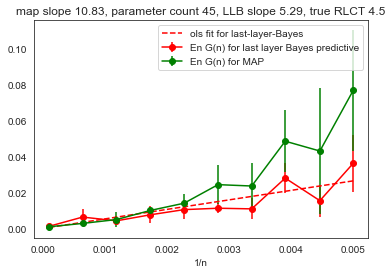

In [14]:
avg_lastlayerbayes_gen_err = np.array([])
std_lastlayerbayes_gen_err = np.array([])
avg_map_gen_err = np.array([])
std_map_gen_err = np.array([])
avg_entropy = np.array([])
std_entropy = np.array([])

n_range = np.round(1/np.linspace(1/200,1/10000,args.num_n))

for n in n_range:

    map_gen_err = np.empty(args.MCs)
    lastlayerbayes_gen_err = np.empty(args.MCs)
    entropy_array = np.empty(args.MCs)

    args.n = n

    for mc in range(0, args.MCs):

        train_loader, valid_loader, test_loader, oracle_mse, entropy = get_data(args)
        entropy_array[mc] = entropy

        X_train = train_loader.dataset[:][0]
        Y_train = train_loader.dataset[:][1]
        X_valid = valid_loader.dataset[:][0]
        Y_valid = valid_loader.dataset[:][1]
        X_test = test_loader.dataset[:][0]
        Y_test = test_loader.dataset[:][1]

        model = map_train(args, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, oracle_mse)

        model.eval()
        map_gen_err[mc] = -torch.log((2*np.pi)**(-args.output_dim /2) * torch.exp(-(1/2) * torch.norm(Y_test-model(X_test), dim=1)**2)).mean() - entropy

        Bmap = list(model.parameters())[-1]
        Amap = list(model.parameters())[-2]
        params = (args.input_dim, args.output_dim, np.linalg.matrix_rank(torch.matmul(Bmap, Amap).detach().numpy()), args.rr_hidden)
        trueRLCT = theoretical_RLCT('rr', params)
        print('true RLCT {}'.format(trueRLCT))

        lastlayerbayes_gen_err[mc] = lastlayer_approxinf(model, args, X_train, Y_train, X_valid, Y_valid, X_test, Y_test) - entropy

        print('n = {}, mc {}, gen error: map {}, bayes last layer {}'
              .format(n, mc, map_gen_err[mc], lastlayerbayes_gen_err[mc]))


    print('average gen error: MAP {}, bayes {}'
          .format(map_gen_err.mean(), lastlayerbayes_gen_err.mean()))

    avg_lastlayerbayes_gen_err = np.append(avg_lastlayerbayes_gen_err, lastlayerbayes_gen_err.mean())
    std_lastlayerbayes_gen_err = np.append(std_lastlayerbayes_gen_err, lastlayerbayes_gen_err.std())
    avg_map_gen_err = np.append(avg_map_gen_err, map_gen_err.mean())
    std_map_gen_err = np.append(std_map_gen_err, map_gen_err.std())
    avg_entropy = np.append(avg_entropy, entropy_array.mean())
    std_entropy = np.append(std_entropy, entropy_array.std())

print('avg LLB gen err {}, std {}'.format(avg_lastlayerbayes_gen_err, std_lastlayerbayes_gen_err))
print('avg MAP gen err {}, std {}'.format(avg_map_gen_err, std_map_gen_err))


if args.realizable:
    ols_map = OLS(avg_map_gen_err, 1 / n_range).fit()
    map_slope = ols_map.params[0]

    ols_llb = OLS(avg_lastlayerbayes_gen_err, 1 / n_range).fit()
    llb_intercept = 0.0
    llb_slope = ols_llb.params[0]
else:
    ols_map = OLS(avg_map_gen_err, add_constant(1 / n_range)).fit()
    map_slope = ols_map.params[1]

    ols_llb = OLS(avg_lastlayerbayes_gen_err, add_constant(1 / n_range)).fit()
    llb_intercept = ols_llb.params[0]
    llb_slope = ols_llb.params[1]

print('estimated RLCT {}'.format(llb_slope))
#
fig, ax = plt.subplots()
ax.errorbar(1/n_range, avg_lastlayerbayes_gen_err, yerr=std_lastlayerbayes_gen_err, fmt='-o', c='r', label='En G(n) for last layer Bayes predictive')
ax.errorbar(1/n_range, avg_map_gen_err, yerr=std_map_gen_err, fmt='-o', c='g', label='En G(n) for MAP')
plt.plot(1 / n_range, llb_intercept + llb_slope / n_range, 'r--', label='ols fit for last-layer-Bayes')
plt.xlabel('1/n')
plt.title('map slope {:.2f}, parameter count {}, LLB slope {:.2f}, true RLCT {}'.format(map_slope, total_param_count, llb_slope, trueRLCT))
plt.legend()
plt.savefig('taskid{}.png'.format(args.taskid))
plt.show()

The graph produced plots $1/n$ versus average generalizaton error $E_n G(n)$ for MAP predictor and LLB predictive distribution. Vertical bars indicate 1 std deviation over the different Monte Carlo training-testing sets. The LLB learning coefficient (LLB slope) indicated in the title of the graph should match the "true RLCT." In addition, the MAP learning coefficient (map slope) should be bigger than the LLB slope according to theory. 